# 🤟 BISINDO Sign Language Recognition - Training (Fixed)

**Perbaikan dari versi sebelumnya:**
1. ✅ Split data SEBELUM augmentation
2. ✅ Kurangi regularisasi (L2 & Dropout)
3. ✅ Disable class weights (data sudah balanced)
4. ✅ Augmentation lebih ringan
5. ✅ Proper validation set (data asli, bukan augmented)

## 1. Setup & Mount Google Drive

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import numpy as np
import pickle
import json
import os
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Set random seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Load Data

In [15]:
# ============================================
# SESUAIKAN PATH INI
# ============================================
DATA_DIR = "/content/drive/MyDrive/BisindoCV_Data/processed"
MODEL_DIR = "/content/drive/MyDrive/BisindoCV_Data/models"

os.makedirs(MODEL_DIR, exist_ok=True)

# Load data
print("Loading data...")
X_train_full = np.load(f"{DATA_DIR}/X_train.npy")
X_test = np.load(f"{DATA_DIR}/X_test.npy")
y_train_full = np.load(f"{DATA_DIR}/y_train.npy")
y_test = np.load(f"{DATA_DIR}/y_test.npy")

with open(f"{DATA_DIR}/label_encoder.pkl", 'rb') as f:
    label_encoder = pickle.load(f)

print(f"X_train_full: {X_train_full.shape}")
print(f"X_test: {X_test.shape}")
print(f"Classes: {len(label_encoder.classes_)}")
print(f"Class names: {list(label_encoder.classes_)}")

num_classes = len(label_encoder.classes_)
sequence_length = X_train_full.shape[1]
num_features = X_train_full.shape[2]

Loading data...
X_train_full: (364, 60, 154)
X_test: (91, 60, 154)
Classes: 7
Class names: [np.str_('Jijik'), np.str_('Marah'), np.str_('Neutral'), np.str_('Sedih'), np.str_('Senang'), np.str_('Takut'), np.str_('Terkejut')]


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## 3. Split Data SEBELUM Augmentation (PENTING!)

**Ini adalah perbaikan utama!**
- Validation set harus berisi data ASLI (tidak augmented)
- Augmentation hanya diterapkan ke training set

In [16]:
# ============================================
# SPLIT SEBELUM AUGMENTATION
# ============================================
VAL_SIZE = 0.15  # 15% untuk validation

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=VAL_SIZE,
    stratify=y_train_full,
    random_state=SEED
)

print(f"After split:")
print(f"  X_train (for augmentation): {X_train.shape}")
print(f"  X_val (original data only): {X_val.shape}")
print(f"  X_test: {X_test.shape}")

After split:
  X_train (for augmentation): (309, 60, 154)
  X_val (original data only): (55, 60, 154)
  X_test: (91, 60, 154)


## 4. Data Augmentation (Lebih Ringan)

In [17]:
# ============================================
# AUGMENTATION FUNCTIONS (Lebih ringan)
# ============================================

def add_noise(X, noise_factor=0.01):
    """Add Gaussian noise - RINGAN."""
    noise = np.random.normal(0, noise_factor, X.shape)
    return X + noise

# def time_shift(X, shift_max=2):
#     """Shift sequence in time - RINGAN."""
#     X_shifted = np.zeros_like(X)
#     for i in range(len(X)):
#         shift = np.random.randint(-shift_max, shift_max + 1)
#         if shift > 0:
#             X_shifted[i, shift:] = X[i, :-shift]
#             X_shifted[i, :shift] = X[i, 0]  # Repeat first frame
#         elif shift < 0:
#             X_shifted[i, :shift] = X[i, -shift:]
#             X_shifted[i, shift:] = X[i, -1]  # Repeat last frame
#         else:
#             X_shifted[i] = X[i]
#     return X_shifted

def scale_landmarks(X, scale_range=(0.95, 1.05)):
    """Scale landmarks randomly - RINGAN."""
    scales = np.random.uniform(scale_range[0], scale_range[1], (len(X), 1, 1))
    return X * scales

In [18]:
# ============================================
# APPLY AUGMENTATION (Hanya ke training set!)
# ============================================

print("Augmenting training data...")

# Augmentasi RINGAN - hanya 2x data asli
X_train_aug1 = add_noise(X_train, noise_factor=0.015)
# X_train_aug2 = time_shift(X_train, shift_max=2)

# Gabungkan: original + 2 augmented = 3x data
X_train_combined = np.concatenate([
    X_train,       # Original
    X_train_aug1,  # Noise
    # X_train_aug2,  # Time shift
], axis=0)

y_train_combined = np.concatenate([
    y_train,
    y_train,
    y_train,
], axis=0)

# Shuffle
shuffle_idx = np.random.permutation(len(X_train_combined))
X_train_combined = X_train_combined[shuffle_idx]
y_train_combined = y_train_combined[shuffle_idx]

print(f"\nOriginal training: {len(X_train)}")
print(f"After augmentation: {len(X_train_combined)} (3x)")
print(f"Validation (NO augmentation): {len(X_val)}")

Augmenting training data...

Original training: 309
After augmentation: 618 (3x)
Validation (NO augmentation): 55


In [19]:
# ============================================
# ONE-HOT ENCODE
# ============================================

y_train_cat = to_categorical(y_train_combined, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"y_train_cat: {y_train_cat.shape}")
print(f"y_val_cat: {y_val_cat.shape}")
print(f"y_test_cat: {y_test_cat.shape}")

y_train_cat: (618, 7)
y_val_cat: (55, 7)
y_test_cat: (91, 7)


## 5. Model Architecture (Regularisasi Dikurangi)

In [20]:
def build_bilstm_model(sequence_length, num_features, num_classes):
    """
    BiLSTM dengan regularisasi RINGAN.

    Perubahan dari sebelumnya:
    - L2 regularization: 0.001 -> 0.0001
    - Dropout: 0.4-0.5 -> 0.2-0.3
    """
    inputs = layers.Input(shape=(sequence_length, num_features))

    # Batch normalization on input
    x = layers.BatchNormalization()(inputs)

    # First BiLSTM layer - KURANGI regularisasi
    x = layers.Bidirectional(
        layers.LSTM(128, return_sequences=True,
                    kernel_regularizer=regularizers.l2(0.0005),  # Dikurangi
                    recurrent_regularizer=regularizers.l2(0.0005))  # Dikurangi
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)  # Dikurangi dari 0.4

    # Second BiLSTM layer
    x = layers.Bidirectional(
        layers.LSTM(64, return_sequences=True,
                    kernel_regularizer=regularizers.l2(0.0005),
                    recurrent_regularizer=regularizers.l2(0.0005))
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)  # Dikurangi dari 0.4

    # Third BiLSTM layer
    x = layers.Bidirectional(
        layers.LSTM(32, return_sequences=False,
                    kernel_regularizer=regularizers.l2(0.0005))
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)  # Dikurangi dari 0.4

    # Dense layers - KURANGI regularisasi
    x = layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(0.0005))(x)  # Dikurangi
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)  # Dikurangi dari 0.5 - 0.3

    x = layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(0.0005))(x)
    x = layers.Dropout(0.2)(x)  # Dikurangi dari 0.3 - 0.2

    # Output
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


def build_simple_lstm(sequence_length, num_features, num_classes):
    """
    Simple LSTM - untuk baseline atau dataset kecil.
    """
    model = keras.Sequential([
        layers.Input(shape=(sequence_length, num_features)),

        layers.BatchNormalization(),

        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),

        layers.LSTM(32, return_sequences=False),
        layers.Dropout(0.2),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.4),

        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [21]:
# ============================================
# BUILD MODEL
# ============================================

# Pilih model:
USE_SIMPLE_MODEL = False  # True untuk dataset sangat kecil (<100 samples)

if USE_SIMPLE_MODEL:
    model = build_simple_lstm(sequence_length, num_features, num_classes)
    model_name = "bisindo_simple_lstm"
else:
    model = build_bilstm_model(sequence_length, num_features, num_classes)
    model_name = "bisindo_bilstm_fixed"

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 154)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 60, 154)        │           616 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 60, 256)        │       289,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 60, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 515,311 (1.97 MB)

 Trainable params: 513,851 (1.96 MB)

 Non-trainable params: 1,460 (5.70 KB)

## 6. Compile & Callbacks

In [22]:
# ============================================
# COMPILE MODEL
# ============================================

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Sedikit lebih tinggi
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ============================================
# CALLBACKS
# ============================================

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),

    ModelCheckpoint(
        filepath=f"{MODEL_DIR}/{model_name}_best.keras",
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1
    )
]

print("Model compiled!")

Model compiled!


## 7. Training

**Perubahan penting:**
- Menggunakan `validation_data` (data asli) bukan `validation_split`
- TIDAK menggunakan class_weight (data sudah di-balance)

In [23]:
# ============================================
# TRAINING
# ============================================

EPOCHS = 150
BATCH_SIZE = 16

print(f"\n{'='*60}")
print("TRAINING CONFIG")
print(f"{'='*60}")
print(f"Model: {model_name}")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training samples: {len(X_train_combined)} (augmented)")
print(f"Validation samples: {len(X_val)} (original, NO augmentation)")
print(f"Test samples: {len(X_test)}")
print(f"Class weights: DISABLED (data already balanced)")
print(f"{'='*60}\n")

# TRAINING dengan validation_data (BUKAN validation_split)
history = model.fit(
    X_train_combined, y_train_cat,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val_cat),  # Data asli untuk validasi!
    callbacks=callbacks,
    # class_weight=None,  # TIDAK pakai class weights
    verbose=1
)


TRAINING CONFIG
Model: bisindo_bilstm_fixed
Epochs: 150
Batch size: 16
Training samples: 618 (augmented)
Validation samples: 55 (original, NO augmentation)
Test samples: 91
Class weights: DISABLED (data already balanced)

Epoch 1/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2193 - loss: 3.2274
Epoch 1: val_loss improved from inf to 2.83153, saving model to /content/drive/MyDrive/BisindoCV_Data/models/bisindo_bilstm_fixed_best.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.2207 - loss: 3.2227 - val_accuracy: 0.1818 - val_loss: 2.8315 - learning_rate: 0.0010
Epoch 2/150
37/39 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4678 - loss: 2.4292
Epoch 2: val_loss improved from 2.83153 to 2.80163, saving model to /content/drive/MyDrive/BisindoCV_Data/models/bisindo_bilstm_fixed_best.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4664 - loss: 2.4317 - val_accuracy: 0.2182 - val_loss: 2.8016 - learning_rate: 0.0010
Epoch 3/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 

## 8. Visualisasi Training History

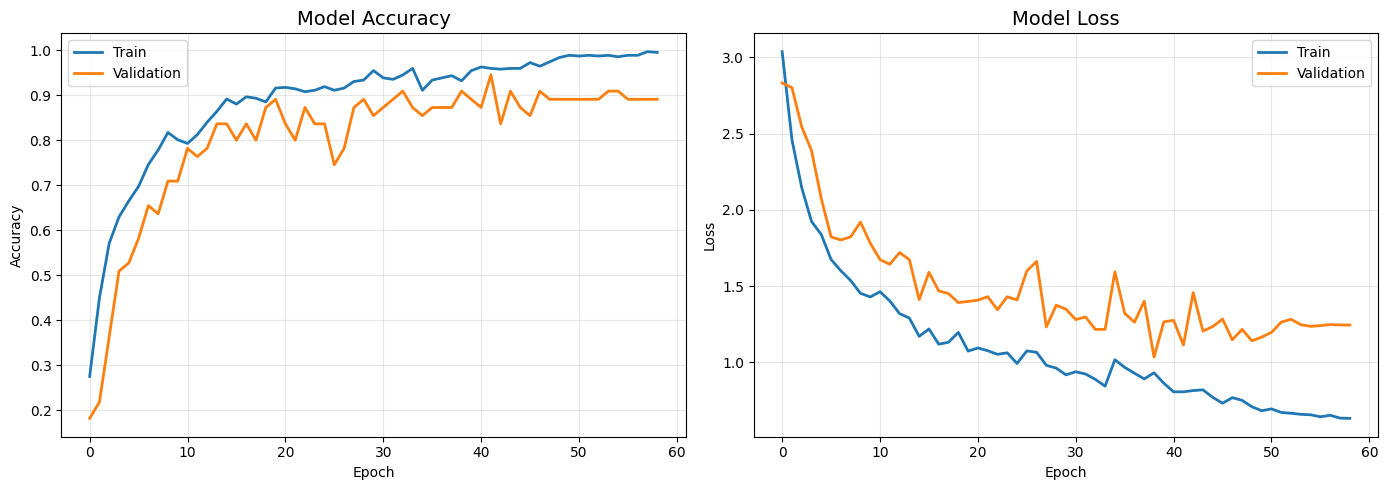


Final Training Accuracy: 99.51%
Final Validation Accuracy: 89.09%
✅ Normal: Train > Val (sedikit overfitting adalah normal)


In [24]:
# ============================================
# PLOT TRAINING HISTORY
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{MODEL_DIR}/{model_name}_history.png", dpi=150)
plt.show()

# Check if training is normal
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"\nFinal Training Accuracy: {final_train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")

if final_train_acc > final_val_acc:
    print("✅ Normal: Train > Val (sedikit overfitting adalah normal)")
else:
    print("⚠️ Unusual: Val > Train (mungkin masih ada masalah)")

## 9. Evaluation

In [25]:
# ============================================
# EVALUATE ON TEST SET
# ============================================

print("Evaluating on test set...")

test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)

print(f"\n{'='*60}")
print("TEST RESULTS")
print(f"{'='*60}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"{'='*60}")

Evaluating on test set...

TEST RESULTS
Test Loss: 1.1996
Test Accuracy: 89.01%


In [26]:
# ============================================
# CLASSIFICATION REPORT
# ============================================

y_pred = np.argmax(model.predict(X_test), axis=1)

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       Jijik       0.83      0.83      0.83        12
       Marah       0.91      0.77      0.83        13
     Neutral       0.79      0.79      0.79        14
       Sedih       0.92      0.92      0.92        13
      Senang       1.00      0.92      0.96        13
       Takut       0.92      1.00      0.96        12
    Terkejut       0.88      1.00      0.93        14

    accuracy                           0.89        91
   macro avg       0.89      0.89      0.89        91
weighted avg       0.89      0.89      0.89        91



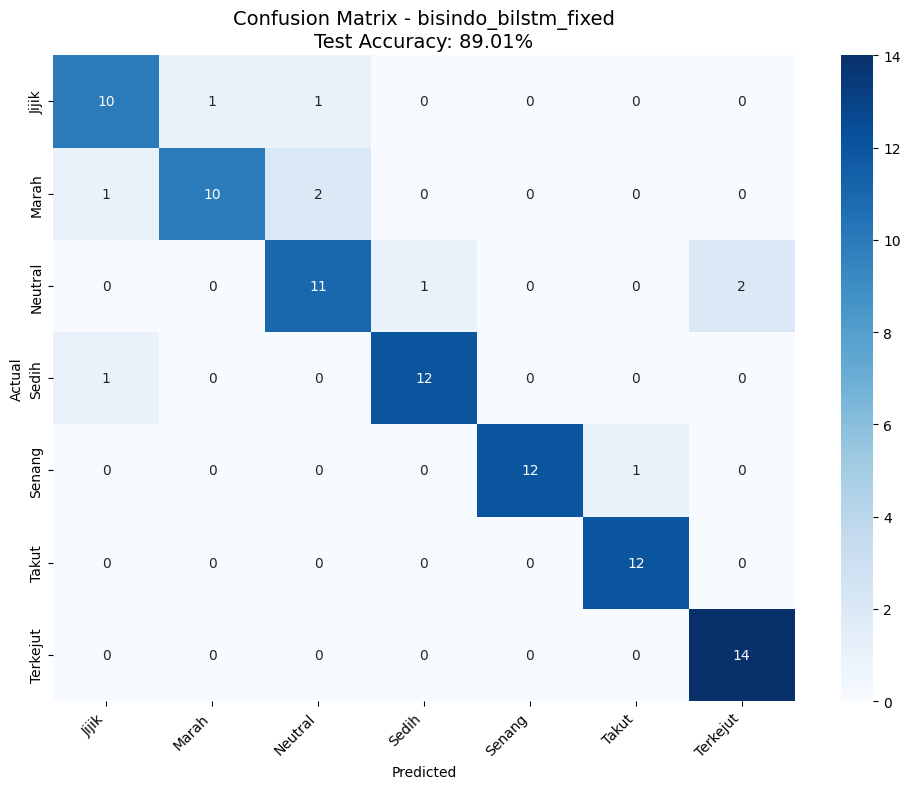

In [27]:
# ============================================
# CONFUSION MATRIX
# ============================================

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title(f'Confusion Matrix - {model_name}\nTest Accuracy: {test_accuracy*100:.2f}%', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"{MODEL_DIR}/{model_name}_confusion_matrix.png", dpi=150)
plt.show()

## 10. Save Model

In [28]:
# ============================================
# SAVE MODEL & INFO
# ============================================

# Save final model
model.save(f"{MODEL_DIR}/{model_name}_final.keras")
print(f"Model saved: {MODEL_DIR}/{model_name}_final.keras")

# Save training info
info = {
    'model_name': model_name,
    'test_accuracy': float(test_accuracy),
    'test_loss': float(test_loss),
    'final_train_accuracy': float(history.history['accuracy'][-1]),
    'final_val_accuracy': float(history.history['val_accuracy'][-1]),
    'epochs_trained': len(history.history['loss']),
    'sequence_length': sequence_length,
    'num_features': num_features,
    'num_classes': num_classes,
    'classes': list(label_encoder.classes_),
    'training_samples': len(X_train_combined),
    'validation_samples': len(X_val),
    'test_samples': len(X_test),
    'augmentation': '3x (original + noise + (w/o time_shift))',
    'fixes_applied': [
        'Split before augmentation',
        'Reduced L2 regularization (0.001 -> 0.0001)',
        'Reduced Dropout (0.4-0.5 -> 0.2-0.3)',
        'Disabled class weights',
        'Lighter augmentation'
    ]
}

with open(f"{MODEL_DIR}/{model_name}_info.json", 'w') as f:
    json.dump(info, f, indent=2)

# Copy label encoder
import shutil
shutil.copy(f"{DATA_DIR}/label_encoder.pkl", f"{MODEL_DIR}/label_encoder.pkl")

print(f"\n{'='*60}")
print("ALL FILES SAVED!")
print(f"{'='*60}")
print(f"  📁 {model_name}_final.keras")
print(f"  📁 {model_name}_best.keras")
print(f"  📁 {model_name}_info.json")
print(f"  📁 {model_name}_history.png")
print(f"  📁 {model_name}_confusion_matrix.png")
print(f"  📁 label_encoder.pkl")

Model saved: /content/drive/MyDrive/BisindoCV_Data/models/bisindo_bilstm_fixed_final.keras

ALL FILES SAVED!
  📁 bisindo_bilstm_fixed_final.keras
  📁 bisindo_bilstm_fixed_best.keras
  📁 bisindo_bilstm_fixed_info.json
  📁 bisindo_bilstm_fixed_history.png
  📁 bisindo_bilstm_fixed_confusion_matrix.png
  📁 label_encoder.pkl


---

## 📊 Checklist Hasil yang Diharapkan

Setelah training, pastikan:

| Metrik | Normal | Tidak Normal |
|--------|--------|---------------|
| Train Accuracy | > Val Accuracy | < Val Accuracy |
| Train Loss | < Val Loss | > Val Loss |
| Gap Train-Val | 5-15% | > 30% (overfitting) |

**Contoh hasil yang baik:**
```
Train Accuracy: 92%
Val Accuracy: 88%
Test Accuracy: 85%
```

---

## 🔧 Troubleshooting

**Jika Val > Train masih terjadi:**
1. Kurangi augmentation (hanya noise)
2. Gunakan `USE_SIMPLE_MODEL = True`
3. Tambah data asli (rekam lebih banyak video)

**Jika accuracy rendah (<60%):**
1. Cek kualitas landmarks extraction
2. Tambah epochs
3. Kurangi learning rate ke 0.0001